<hr>

https://www.tensorflow.org/datasets/catalog/fashion_mnist

https://github.com/zalandoresearch/fashion-mnist

Fashion-MNIST is a dataset of clothing images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [1]:
import numpy as np
import numpy.random as R
import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    from tensorflow.keras.datasets import fashion_mnist
    from tensorflow.keras import models
    from tensorflow.keras import layers
    from tensorflow.keras import optimizers
    from tensorflow.keras.utils import to_categorical

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

flabels = {0 : 't-shirt',
           1 : 'trousers',
           2 : 'pullover',
           3 : 'dress',
           4 : 'coat',
           5 : 'sandal',
           6 : 'shirt',
           7 : 'sneaker',
           8 : 'bag',
           9 : 'boot'}

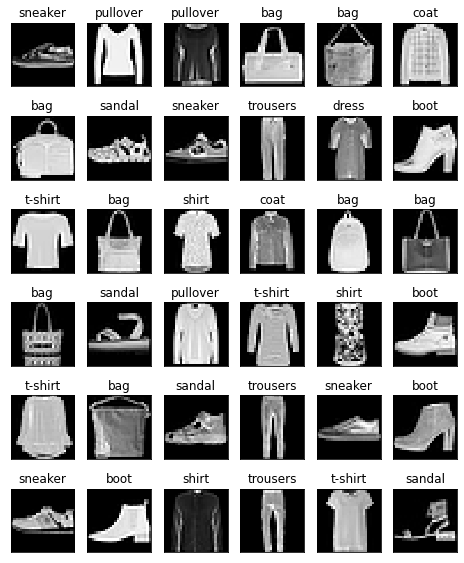

In [2]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
N = 6
st_idx = R.randint(0, train_images.shape[0]-N*N-1)
for i in range(N*N):
    plt.subplot(N,N,i+1)
    plt.imshow(train_images[st_idx+i], cmap='gray', interpolation='none')
    plt.title(flabels[train_labels[st_idx+i]])
    plt.xticks([])
    plt.yticks([])
plt.show()

## Q1a: Autoassociator

Note on Homework 7 that for the autoencoder (Q1a), you should use linear activation functions on the outputs (as a regression-type problem). For this, I've asked you to have it develop PCA-like representations, which means also using linear activation functions on the hidden layer. With a regression-type problem, mean_squared_error is an appropriate loss function

(I just realized that the autoencoder code I shared in Homework 1 used a nonlinear hidden layer, which is fine but not PCA-like, had sigmoidal output activations, which is ok since the pixel values are normalized to fall between 0 and 1, but had an inappropriate objective function - I think I copied that code from someplace at one time and hadn't bothered to check it closely since it was just a quick demo to make sure Keras/Tensorflow was working.)

In [3]:
def plot_model_loss(history):
    """Loss Plotting Function"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss As a Function of Number of Epochs Trained')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()
    
def plot_model_accuracy(history):
    """Accuracy Plotting Function"""
    plt.plot(history.history['acc'])
    plt.title('Model Accuracy As a Function of Number of Epochs Trained')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()

In [4]:
# Reshape the training images to be a flattened 2D representation
base_dim = train_images.shape[1]
new_dim = train_images.shape[1] * train_images.shape[2]
train_2D = np.reshape(train_images, (train_images.shape[0], new_dim))

# Expand the training labels to be 2D
train_labels = np.reshape(train_labels, (train_labels.shape[0], 1))

# Shuffle all vector (THE SAME ORDER)
shuffled_idx = R.permutation(train_2D.shape[0])
train_shuffled = train_2D[shuffled_idx,:]
train_labels_shuffled = train_labels[shuffled_idx,:]

# Take half of the above for the training data for Q1a
train_half = train_shuffled[0:train_shuffled.shape[0]//2]
train_labels_half = train_labels_shuffled[0:train_shuffled.shape[0]//2]

train_imagesREMAKE_shuffled = np.reshape(train_shuffled, (train_shuffled.shape[0],28,28))

In [5]:
def generate_aa(encoding_dim, act1, act2, loss_func, train_half, train_half_labels, my_epochs=20, my_batch=256):
    # this is our input placeholder
    input_img = layers.Input(shape=(new_dim,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation=act1)(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(new_dim, activation=act2)(encoded)

    # this model maps an input to its reconstruction
    autoencoder = models.Model(input_img, decoded)

    # this model maps an input to its encoded representation
    encoder = models.Model(input_img, encoded)

    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = layers.Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = models.Model(encoded_input, decoder_layer(encoded_input))

    # compile model
    autoencoder.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

    assert(train_half.shape[0] == train_labels_half.shape[0])
    assert(train_labels_half.shape[1] == 1)

    # My code here
    x_train = train_half[0:int(train_half.shape[0]*0.8), :]
    x_test = train_half[int(train_labels_half.shape[0]*0.8):, :]

    x_train = x_train / np.amax(train_half)
    x_test = x_test / np.amax(train_half)

    assert(x_test.shape[0] + x_train.shape[0] == train_half.shape[0])

    history = autoencoder.fit(x_train, x_train,
                    epochs=my_epochs,
                    batch_size=my_batch,
                    verbose = False,
                    shuffle=True,
                    validation_data=(x_test, x_test))

    plot_model_loss(history)
    
    return autoencoder, history

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


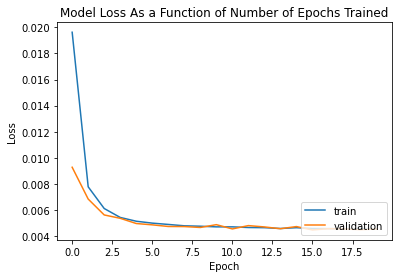

In [6]:
encoding_dim = 200
aa200, aahistory = generate_aa(encoding_dim, 'linear', 'linear', 'mean_squared_error', train_half, train_labels_half, my_batch=30)

In [7]:
aa_output = aa200.predict(
   train_half, 
   batch_size = 30, 
   verbose = False, 
)

train_half_REFORMAT = np.reshape(train_half, (train_half.shape[0], base_dim, base_dim))
aa_output_REFORMAT = np.reshape(aa_output, (aa_output.shape[0], base_dim, base_dim))

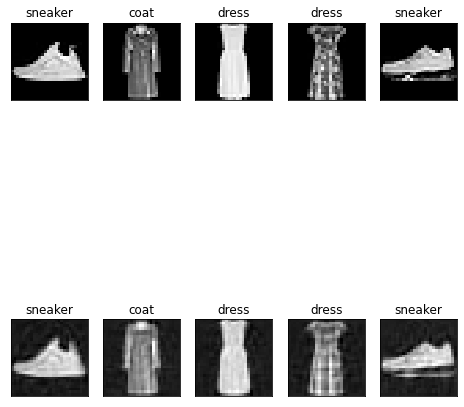

In [8]:
# display some images with their labels
fig = plt.figure(figsize=(8, 10))
for i in range(10):
    plt.subplot(2,5,i+1)
    if i < 5:
        plt.imshow(train_half_REFORMAT[i], cmap='gray', interpolation='none')
        plt.title(flabels[train_labels_half[i, 0]])
    else:
        plt.imshow(aa_output_REFORMAT[i-5], cmap='gray', interpolation='none')
        plt.title(flabels[train_labels_half[i-5, 0]])
    plt.xticks([])
    plt.yticks([])
plt.show()

The above cell shows the performance when the dimensionality is reduced to 200

The below cell shows when the dimensionality is reduced to just 10.  See the following paragraph for why the 200 was still chosen.

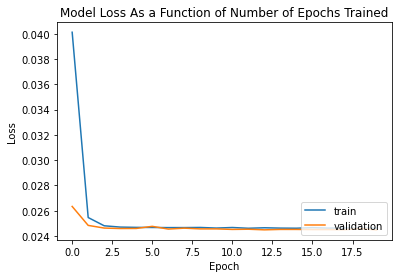

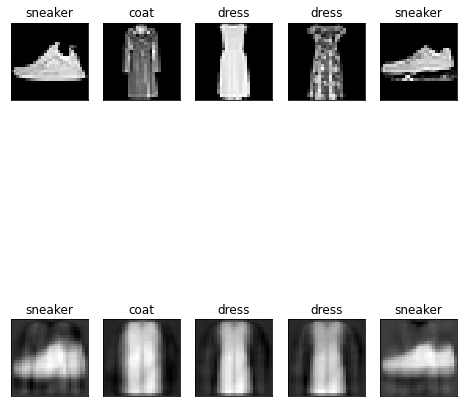

In [9]:
encoding_dim10 = 10
aa10, aahistory = generate_aa(encoding_dim10, 'linear', 'linear', 'mean_squared_error', train_half, train_labels_half, my_batch=30)

aa_output = aa10.predict(
   train_half, 
   batch_size = 30, 
   verbose = False, 
)

train_half_REFORMAT = np.reshape(train_half, (train_half.shape[0], base_dim, base_dim))
aa_output_REFORMAT = np.reshape(aa_output, (aa_output.shape[0], base_dim, base_dim))

# display some images with their labels
fig = plt.figure(figsize=(8, 10))
for i in range(10):
    plt.subplot(2,5,i+1)
    if i < 5:
        plt.imshow(train_half_REFORMAT[i], cmap='gray', interpolation='none')
        plt.title(flabels[train_labels_half[i, 0]])
    else:
        plt.imshow(aa_output_REFORMAT[i-5], cmap='gray', interpolation='none')
        plt.title(flabels[train_labels_half[i-5, 0]])
    plt.xticks([])
    plt.yticks([])
plt.show()

In order to get the results above, I tried a number of different encoding dimensions (e.g. what the network should be compressed down to).  Given that the input dimension is 784 to begin with, I assumed that anything greater than half of that would be a pointless dimensionality reduction (e.g. not must use out of reducing the dimensionality down to 90% of the original size).  This gave an upper bound of ~350.  I also saw the PCA Example code, in which the MNIST digits were compressed from 784 down to 40; in this case, since we are using clothing not just digits, and clothing has more features (e.g. not just an outline / line), 40 established the absolute lower bound.  Through trial and error, I found that epochs should be below 40 and that batch size above ~200 made for "shaky" models in that there were not smooth loss curves.  I also noticed, as one might assume, that the more the dimensionality was reduced, the greater the loss.  Going from 40 to 80 takes the loss from 0.014 to 0.010, whereas 80 to 160 takes the loss from 0.010 to 0.006.  Thus, doubling the number of dimensions results in just less than a 50% performance boost in terms of loss, and more specifically this function is exponential decay and thus exhibits diminishing marginal returns for each amount that we increase the number of dimensions by.  Thus, I took the "elbow point" which looked to be around about 200.

This was then verified by plotting the images (e.g. the output of the autoassociator).  Note that above shows that even 10 nodes appears to be sufficient to get fuzzy images of inputs: **the big caveat is that when using less than 100 nodes, the accuracy needed for Q1b is terrible and unrecoverable** (e.g. can't just wiggle around the batch size or epochs to improve it, within reason anyway).  With a network size of 100, the accuracy was capped at around 92/93%, whereas using 200 (which is a reduction down to a quarter of the original dimensions, which seemed fair) was able to generate accuracies between 95 and 97%.  Thus 200 was used.

## Q1b
> Use the remaining half of the original set as inputs to train a densely connected multilayer NN that learns, via backpropagation to classify the images.

1. Pick the proper activiation functions n the hidden units
2. Pick the proper activation function on the output units for a classificaiotn network
3. Make sure you also pick a proper loss function for a classification network

--> Multiclass classification: Relu, softmax, categorical_cross_entropy

In [10]:
def create_network(node_list, func_list=['relu'], my_opt='adam', loss_func='categorical_crossentropy'):
    network = models.Sequential()
        
    for idx, arg in enumerate(node_list):
        if idx == 0:
            n_prev = arg
        elif idx == len(node_list)-1:
            my_func = 'softmax'
            network.add(layers.Dense(arg, 
                             activation=my_func, 
                             input_shape=(n_prev,)))
        else:
            network.add(layers.Dense(arg, 
                                     activation=func_list[0], 
                                     input_shape=(n_prev,)))
    
    # configure optimizer
    # sgd = optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9)
    network.compile(optimizer=my_opt, 
                    loss=loss_func, 
                    metrics=['accuracy', 'mse'])
    
    return network

In [11]:
train_half2 = train_shuffled[train_shuffled.shape[0]//2:]
train_labels_half2 = train_labels_shuffled[train_shuffled.shape[0]//2:]

print(train_half2.shape)
print(train_labels_half2.shape)

(30000, 784)
(30000, 1)


In [12]:
aanetwork = aa200
aanetwork.summary()

aaW = aanetwork.layers[1].get_weights()[0]
aab = aanetwork.layers[1].get_weights()[1]

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 200)               157000    
_________________________________________________________________
dense_1 (Dense)              (None, 784)               157584    
Total params: 314,584
Trainable params: 314,584
Non-trainable params: 0
_________________________________________________________________


In [13]:
backprop_network = create_network(node_list=[encoding_dim,30,40,10])
backprop_network.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 30)                6030      
_________________________________________________________________
dense_5 (Dense)              (None, 40)                1240      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                410       
Total params: 7,680
Trainable params: 7,680
Non-trainable params: 0
_________________________________________________________________


In [14]:
def apply_weights(aaW, aab, inputs):
    x = np.matmul(inputs, aaW) + aab
    # Linear activation function implies "no" activation function
    return x

# y = mx + b
# fixed_inputs = W * original_inputs + b

print(train_half2.shape)
fixed_input = apply_weights(aaW, aab, train_half2)
print(fixed_input.shape)

# need to categorically encode the labels as "one hot"
train_labels_half2RE = to_categorical(train_labels_half2)

(30000, 784)
(30000, 200)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 120)               24120     
_________________________________________________________________
dense_8 (Dense)              (None, 50)                6050      
_________________________________________________________________
dense_9 (Dense)              (None, 10)                510       
Total params: 30,680
Trainable params: 30,680
Non-trainable params: 0
_________________________________________________________________


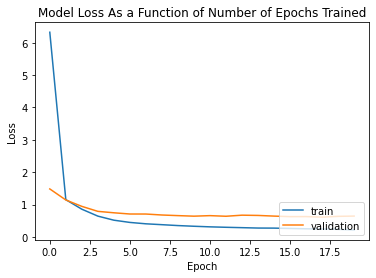

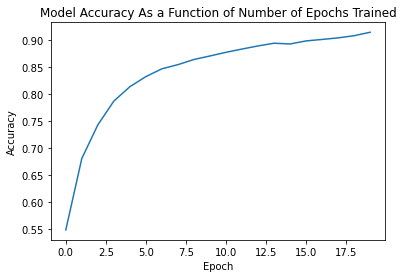

0.915125


In [15]:
backprop_network = create_network(node_list=[encoding_dim,120,50,10])
backprop_network.summary()

my_epochs = 20
my_batch = 128

history2 = backprop_network.fit(fixed_input, 
                              train_labels_half2RE, 
                              verbose=False, 
                              validation_split=.2, 
                              epochs=my_epochs, 
                              batch_size=my_batch)

plot_model_loss(history2)
plot_model_accuracy(history2)
print(history2.history['acc'][-1])

Now evaluate the network using the test data.  No changes will be made based on this performance.

In [16]:
test_imagesRE = np.reshape(test_images, (test_images.shape[0], test_images.shape[1]*test_images.shape[1]))

fixed_input_TEST = apply_weights(aaW, aab, test_imagesRE)
print(fixed_input_TEST.shape)

# need to categorically encode the labels as "one hot"
test_labelsCAT = to_categorical(test_labels)

backprop_network.evaluate(fixed_input_TEST, test_labelsCAT)

(10000, 200)
10000/10000 [==============================] - 1s 58us/sample - loss: 0.7237 - acc: 0.8399 - mean_squared_error: 0.0242


[0.7236728822290898, 0.8399, 0.024198277]

The final model of 200 x 120 x 50 x 10 was chosen after iterating through a number of options.  Of course, using a higher number of hidden layer and nodes increase the performance.  However, increasing the number of layers still required that each layer have at least around 100ish nodes or adding an additional layer would simply decrease performance: thus adding an arbitrary number of layers was not a good design and furthermore adding more layers, even when used to increase perfomance, required a large number of nodes to be included.  Additionally, it was observed that using a first layer with less than 100 nodes resulted in performances less than 90%.  Doing a number of iterations revealed that the given model performaned the best when controlling for the number of nodes (e.g. for a constant number of nodes, this combination of layers and nodes per layer out performed other architectures).  Performance can easily reach upwards of 99% if more hidden nodes are used.

## Q2: Use a CNN to Classify the Fashion MNIST

1. padding='valid'
    1. ^This is the default. It stays inside the previous layer
    2. 'same' --> Goes outside previous layer --> This is what we "may want to use"
2.  strides=(1,1)
    1. ^(default) convolution full covers previous layer
    2. Usually use full stride
    3. strides=(2,2) has gaps

In [17]:
input_sz = base_dim

# Reformat images to be "4D"
train_imagesRE1 = train_images.reshape(train_images.shape[0], input_sz, input_sz, 1)
test_imagesRE1 = test_images.reshape(test_images.shape[0], input_sz, input_sz, 1)

# Normalize
train_imagesRE = train_imagesRE1/255
test_imagesRE = test_imagesRE1/255

# check out dimensions and types of mnist data
print('Training labels shape: ', train_labels.shape)
print('Training labels type:  ', type(train_labels[0]))
print()

# check out what the first 9 labels look like
print("First 9 training labels as labels:\n", train_labels[:9])
print()

# need to categorically encode the labels as "one hot"
train_labelsRE = to_categorical(train_labels)
test_labelsRE = to_categorical(test_labels)

print("First 9 training labels as one-hot encoded vectors:\n", train_labelsRE[:9])

Training labels shape:  (60000, 1)
Training labels type:   <class 'numpy.ndarray'>

First 9 training labels as labels:
 [[9]
 [0]
 [0]
 [3]
 [0]
 [2]
 [7]
 [2]
 [5]]

First 9 training labels as one-hot encoded vectors:
 [[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [18]:
network = models.Sequential()
# first convolution layer parameters
num_fm_1 = 16
conv_dim = 3
# second convolution layer parameters
num_fm_2 = 24
# max pooling parameters
mp_dim = 2
nout = 10
# Dense params
dense1 = 40
dense2 = 20

# first convolution layer
network.add(layers.Conv2D(num_fm_1, (conv_dim, conv_dim), 
                          activation='relu', 
                          input_shape=(input_sz, input_sz, 1)))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

# second convolution layer
network.add(layers.Conv2D(num_fm_1*4, (conv_dim, conv_dim), padding='same'))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(num_fm_2*2, (conv_dim,conv_dim), padding='same', activation='relu'))
# max pooling
network.add(layers.MaxPooling2D(mp_dim, mp_dim))

network.add(layers.Conv2D(num_fm_2, (conv_dim,conv_dim), padding='same', activation='relu'))
network.add(layers.Conv2D(num_fm_1, (conv_dim,conv_dim), padding='same', activation='relu'))

network.add(layers.Flatten())
network.add(layers.Dense(dense1, activation='relu'))
network.add(layers.Dense(dense2, activation='relu'))
network.add(layers.Dense(nout, activation='softmax'))

network.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
network.summary()

history = network.fit(train_imagesRE, train_labelsRE, verbose=False,
                      validation_split=.2, epochs=20, batch_size=256)

test_loss, test_accuracy = network.evaluate(test_imagesRE, test_labelsRE)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 48)          27696     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 48)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 24)         

In [19]:
print('test_acc:', test_accuracy)

test_acc: 0.9077


Using the above network, I was able to get an accuracy above 90%.  Most of the models I tried hovered around 85-87%, so this was taken as a success, especially given that the Fashion MNIST is a much more complex dataset than say the MNIST digits dataset.  I started by using the examples of layers/configurations shown in the class slides, which resulted in a performance of 85%, and by varying parameters (mainly, adding more layers) I was able to increase the performance.  Some things I noticed while iterating were that you cannot use "random" values for the convolution input dimension, and furthermore adding excessive strides or excessive convolution "square" sizes also threw off the accuracy by a great deal.  I was able to get higher accuracies, but at the cost of using many more layers.  I experimented with the number of convolution layer as well as the presence (or lack thereof) of max poolings in beween, and I found this architecture to be the best performing for a somewhat reasonable number of parameters.